In [1]:
import os
import numpy as np
import nibabel as nib
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models

%matplotlib inline


Using TensorFlow backend.


In [2]:
def preprocess_data_coronal(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[3]
    num_slices = X.shape[2]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_data_saggital(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))

In [3]:
#Load in real DWI data
X_header = nib.load('../data/real/dwi/dwi.nii.gz')
X = X_header.get_data()
X = np.moveaxis(X,3,0)

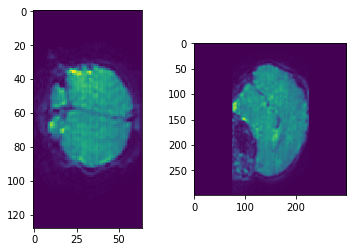

In [4]:
X_test = preprocess_data_saggital(X)

plt.subplot(1,2,1)
plt.imshow(X[0,:,36,:])
plt.subplot(1,2,2)
plt.imshow(X_test[0,:,:,0])

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
from keras import models
#from sklearn.model_selection import accuracy

model_coronal =   models.load_model('keras_logs/coronal_model.hdf5')
model_saggital=   models.load_model('keras_logs/saggital_model.hdf5')

validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input,
    data_format='channels_last',)

num_slices = 30
validation_batch_size = 4
num_validation_steps = X_test.shape[0]/validation_batch_size
model_predictions_coronal = np.zeros((X_test.shape[0],num_slices))
model_predictions_saggital = np.zeros((X_test.shape[0],num_slices))
y_test_fake = np.ones((X_test.shape[0]))

for i in range(num_slices):
    #Coronal
    X_test_slice = preprocess_data_coronal(X,base_slice = 30+5*i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,y_test_fake,batch_size=validation_batch_size,shuffle=False)
    model_predictions_coronal[:,i] = model_coronal.predict_generator(validation_data_for_testing,num_validation_steps)[:,1]
    
    #saggital
    X_test_slice = preprocess_data_saggital(X,base_slice = 35+2*i)  
    #Redefine validation generator to reset
    validation_data_for_testing = validation_generator.flow(X_test_slice,y_test_fake,batch_size=validation_batch_size,shuffle=False)
    model_predictions_saggital[:,i] = model_saggital.predict_generator(validation_data_for_testing,num_validation_steps)[:,1]
    print('Slices complete:',i)

ResourceExhaustedError: OOM when allocating tensor with shape[4,64,147,147]
	 [[Node: conv2d_3/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_2/Relu, conv2d_3/kernel/read)]]
	 [[Node: dense_2/Softmax/_3713 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_7116_dense_2/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_3/convolution', defined at:
  File "/home/ec2-user/src/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-05c8601a224e>", line 5, in <module>
    model_coronal =   models.load_model('keras_logs/coronal_model.hdf5')
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/models.py", line 239, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/models.py", line 313, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/layers/__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/utils/generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 2497, in from_config
    process_node(layer, node_data)
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 2454, in process_node
    layer(input_tensors[0], **kwargs)
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/ec2-user/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3164, in conv2d
    data_format='NHWC')
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 661, in convolution
    op=op)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 653, in op
    name=name)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[4,64,147,147]
	 [[Node: conv2d_3/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](activation_2/Relu, conv2d_3/kernel/read)]]
	 [[Node: dense_2/Softmax/_3713 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_7116_dense_2/Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [ ]:
print(model_predictions_saggital)
plt.plot(model_predictions_saggital[151,:])
plt.ylim(0,1)
y_pred_coronal = (np.sum(model_predictions_coronal>0.5,axis=1) > 1)
y_pred_saggital = (np.sum(model_predictions_saggital>0.5,axis=1) > 3)
a=zip(np.linspace(0,171,172),y_pred_saggital)
#list(a)

predictions_combined = np.concatenate((model_predictions_coronal_val,model_predictions_saggital_val),axis=1)
svm_classifier = joblib.load('misc_files/svm_classifier.pkl') 

y_pred_svm = svm_classifier.predict(predictions_combined)
y_human = np.load('../data/real/dwi/y_manual.npy')

print(confusion_matrix((y_human==2),y_pred_svm))